### Создание графа Tracking network

In [81]:
import numpy as np
import re
from time import sleep
import chess 
import chess.pgn
import networkx as nx
import matplotlib.pyplot as plt

In [114]:
def algebraic_to_coordinate(algebraic):
    letter, number = algebraic[0], algebraic[1]
    x = ord(letter) - ord('a') + 1
    y = int(number)
    return (x, y)


def coordinate_to_algebraic(coordinate):
    x, y = coordinate
    letter = chr(ord('a') + x - 1)
    number = str(y)
    return letter + number


def intermediate_cells(start, end):
    start_coord = algebraic_to_coordinate(start)
    end_coord = algebraic_to_coordinate(end)
    
    x1, y1 = start_coord
    x2, y2 = end_coord
    
    intermediate = []
    
    x_step = 1 if x1 < x2 else -1 if x1 > x2 else 0
    y_step = 1 if y1 < y2 else -1 if y1 > y2 else 0

    if x_step == 0 or y_step == 0:
        steps = max(abs(x2 - x1), abs(y2 - y1))
    else:
        steps = abs(x2 - x1)

    x, y = x1, y1
    
    
    intermediate.append(coordinate_to_algebraic((x, y)))
    for _ in range(0, steps):
        x += x_step
        y += y_step
        intermediate.append(coordinate_to_algebraic((x, y)))
    
    return intermediate

In [1]:
import os
from tqdm import tqdm
import pickle

def create_tracking_network(input_file_path, output_dir):
    if not os.path.exists(output_dir): 
        os.makedirs(output_dir)
    total_games = 100
    with open(input_file_path) as pgn_file:
        for i in tqdm(range(total_games), desc="Processing games", unit="game"):
            game = chess.pgn.read_game(pgn_file)
            if game is None:
                break
            board = chess.Board()
            G = nx.DiGraph()
            temp = input_file_path.split('.')[0]
            output_path = f'{output_dir}/{temp}_{i}/{game.headers.get("White")}/{game.headers.get("Black")}/{game.headers.get("Result")}/{game.headers.get("WhiteElo")}/{game.headers.get("BlackElo")}/{game.headers.get("Opening")}/{game.headers.get("Variation")}.pickle'
            for number, move in enumerate(game.mainline_moves()):
                figure_type = board.piece_at(chess.parse_square(move.uci()[:2])).symbol()
                board.push(move)
                if figure_type == 'N' or figure_type == 'n':
                    array_of_cells = [move.uci()[:2], move.uci()[2:]]
                else:
                    array_of_cells = intermediate_cells(move.uci()[:2], move.uci()[2:])
                for j in range(len(array_of_cells) - 1):
                    G.add_edge(array_of_cells[j], array_of_cells[j + 1], color="red" if number % 2 == 0 else "black")
            with open(output_path, "wb") as f:
                pickle.dump(G, f)

In [129]:
create_tracking_network("database_part7.pgn", "tracking_network")

Processing games: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 311.60game/s]


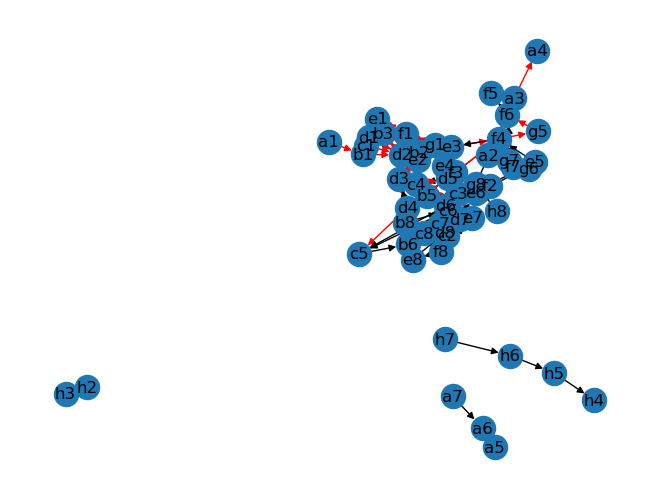

In [132]:
with open("tracking_network/database_part7_0.pickle", 'rb') as f:
    G = pickle.load(f)

edges,colors = zip(*nx.get_edge_attributes(G,'color').items())
nx.draw(G,edgelist=edges, with_labels=True,edge_color=colors,width=1)